In [1]:
from kan import KAN

import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import *

# <center>Pré-processamento dos dados</center>

In [2]:
dataset_path = 'dataset_teste2'

In [3]:
transform_dataset = transforms.Compose(
    [transforms.Resize(size = (164,164)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5], std=[0.5])
    ]
)

In [4]:
dataset = datasets.ImageFolder(dataset_path, transform = transform_dataset)

In [5]:
print("Informações sobre o Dataset: \n\n", dataset)
print("\nRótulos: ", dataset.class_to_idx)

Informações sobre o Dataset: 

 Dataset ImageFolder
    Number of datapoints: 1000
    Root location: dataset_teste2
    StandardTransform
Transform: Compose(
               Resize(size=(164, 164), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )

Rótulos:  {'NORMAL': 0, 'PNEUMONIA': 1, 'TUBERCULOSE': 2}


In [6]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [7]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [8]:
all_targets = []
for images, labels in train_loader:
    all_targets.extend(labels.tolist())

nor = []
pne = []
tub = []
for i in range(700):
    if all_targets[i] == 0:
        nor.append(all_targets[i])
    elif all_targets[i] == 1:
        pne.append(all_targets[i])
    elif all_targets[i] == 2:
        tub.append(all_targets[i])

In [9]:
print("!!!Distribuição dos dados de treinamento!!!\n")
print("Normal: ", len(nor))
print("Pneumonia: ", len(pne))
print("Tuberculose: ", len(tub))

!!!Distribuição dos dados de treinamento!!!

Normal:  236
Pneumonia:  224
Tuberculose:  240


In [10]:
train_data = []
train_targets = []

for batch_data_train, batch_targets_train in train_loader:
    train_data.append(batch_data_train)
    train_targets.append(batch_targets_train)

train_data = torch.cat(train_data, dim=0)
train_targets = torch.cat(train_targets, dim=0)

In [11]:
test_data = []
test_targets = []

for batch_data_test, batch_targets_test in test_loader:
    test_data.append(batch_data_test)
    test_targets.append(batch_targets_test)

test_data = torch.cat(test_data, dim=0)
test_targets = torch.cat(test_targets, dim=0)

In [12]:
dataset = {}

dataset['train_input'] = train_data.view(-1, 164*164*3)
dataset['test_input'] = test_data.view(-1, 164*164*3)
dataset['train_label'] = train_targets
dataset['test_label'] = test_targets

# <center>Implementação da arquitetura KAN</center>

In [13]:
model = KAN(width=[164*164*3, 32, 3], grid=3, k=3, base_fun=torch.nn.ReLU(), auto_save=False)

In [14]:
dtype = torch.get_default_dtype()

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))


In [15]:
results = model.fit(dataset, opt="Adam", steps=250, metrics=(train_acc, test_acc), 
                    loss_fn=torch.nn.CrossEntropyLoss(), lr=0.001, batch=16)

| train_loss: 2.02e-01 | test_loss: 8.65e-02 | reg: 6.35e+03 | : 100%|█| 250/250 [23:53:31<00:00, 34


In [16]:
print("Acurácia dos dados de treino: ", results['train_acc'][-1])
print("Acurácia dos dados de teste: ", results['test_acc'][-1])

Acurácia dos dados de treino:  0.9728571176528931
Acurácia dos dados de teste:  0.8999999761581421


Text(0.5, 0.98, 'Treinamento')

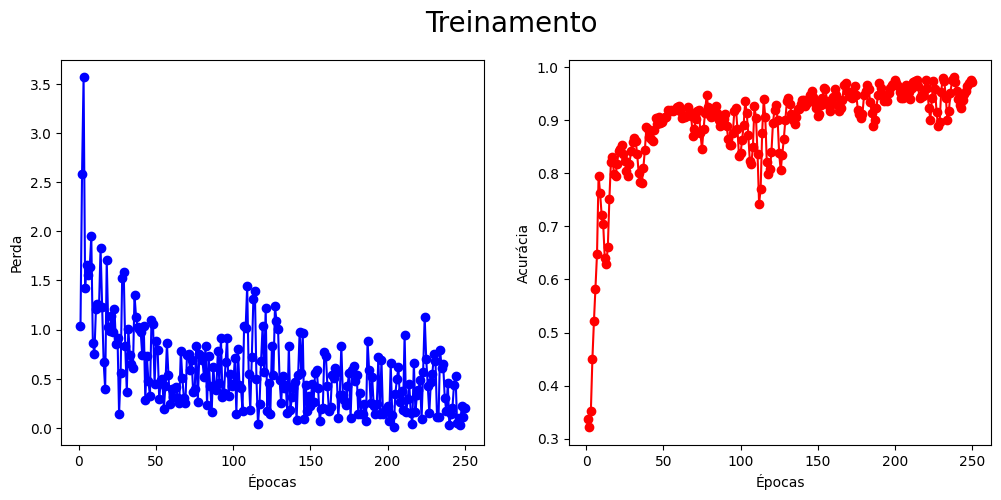

In [18]:
epochs = range(1, 251)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, results['train_loss'], 'bo-')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.subplot(1, 2, 2)
plt.plot(epochs, results['train_acc'], 'ro-')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

plt.suptitle("Treinamento", fontsize = 20)

Text(0.5, 0.98, 'Teste')

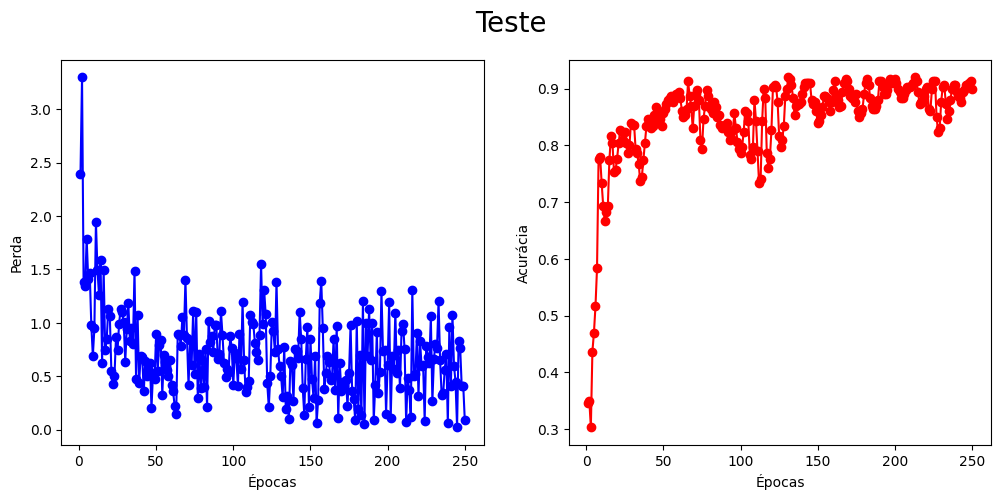

In [19]:
epochs = range(1, 251)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, results['test_loss'], 'bo-')
plt.xlabel('Épocas')
plt.ylabel('Perda')

plt.subplot(1, 2, 2)
plt.plot(epochs, results['test_acc'], 'ro-')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')

plt.suptitle("Teste", fontsize = 20)

In [20]:
rot_array = []
predt_array = []

model.eval()
    
with torch.no_grad():
        
    for images, labels in test_loader:
        images = images.view(-1, 164*164*3)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        rot_array.extend(labels.cpu().detach().numpy())
        predt_array.extend(predicted.cpu().detach().numpy())

print("!!!Teste finalizado!!!")

!!!Teste finalizado!!!


# <center>Métricas de avaliação</center>

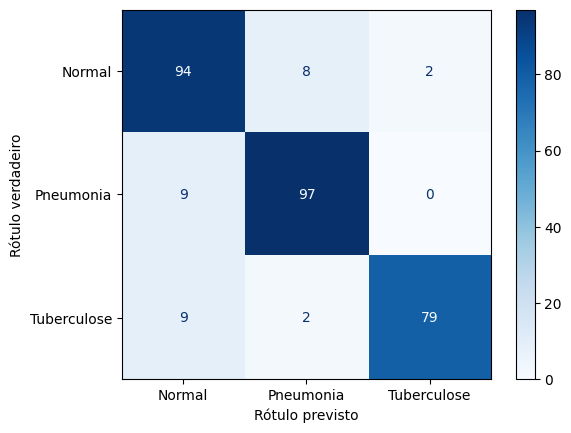

In [21]:
cm = confusion_matrix(rot_array, predt_array)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia', 'Tuberculose'])
disp.plot(cmap=plt.cm.Blues)

plt.xlabel('Rótulo previsto')
plt.ylabel('Rótulo verdadeiro')
plt.show()

In [22]:
acc = accuracy_score(rot_array, predt_array)
print(f"Acurácia: {acc * 100 :.2f}%")

Acurácia: 90.00%


In [23]:
precision = precision_score(rot_array, predt_array, average='weighted')
print(f"Precisão: {precision * 100 :.2f}%")

Precisão: 90.39%


In [24]:
recall = recall_score(rot_array, predt_array, average='weighted')
print(f"Recall: {recall * 100 :.2f}%")

Recall: 90.00%


In [25]:
f1 = f1_score(rot_array, predt_array, average='weighted')
print(f"F1 Score: {f1 * 100 :.2f}%")

F1 Score: 90.07%
